In [167]:
import pandas as pd
from plotnine import *

filename = 'overhead.csv'
data = pd.read_csv(filename)

total_columns = [ 'Init','ConfigFile','SurfaceSetting','SurfaceCompute','InteriorSetting','InteriorCompute']
setup_columns = ['Init','ConfigFile']
stepping_columns = ['SurfaceSetting','SurfaceCompute','InteriorSetting','InteriorCompute','CopyBack']

data['Total Time (s)'] = data[['Init','ConfigFile','SurfaceSetting','SurfaceCompute','InteriorSetting','InteriorCompute']].sum(axis=1) 
data['Setup Time (s)'] = data[['Init','ConfigFile']].sum(axis=1)
data['Surface Time (s)'] = data[['SurfaceSetting','SurfaceCompute']].sum(axis=1)
data['Interior Time (s)'] = data[['InteriorSetting','InteriorCompute']].sum(axis=1)
data['Stepping Time (s)'] = data['Surface Time (s)'] + data['Interior Time (s)']

data['Compute Time (s)'] = data[['SurfaceCompute','InteriorCompute']].sum(axis=1)
data['Setting Time (s)'] = data[['SurfaceSetting','InteriorSetting']].sum(axis=1)

#data = data[data['Version'] != "Chapel"]
data = data.drop('IO', axis=1)
data['OceanColumns'] = 5 * data['NumRuns']
data

,Version,NumRuns,ConfigFile,Init,SurfaceSetting,SurfaceCompute,InteriorSetting,InteriorCompute,CopyBack,Total Time (s),Setup Time (s),Surface Time (s),Interior Time (s),Stepping Time (s),Compute Time (s),Setting Time (s),OceanColumns
0,Fortran,50,0.311000,2.06460,0.000100,0.002000,0.000400,0.034600,0.0005,2.412700,2.375600,0.002100,0.035000,0.037100,0.036600,0.000500,250
1,Chapel,50,0.247135,1.68774,0.001650,0.005940,0.001957,0.051267,NaN,1.995689,1.934875,0.007590,0.053224,0.060814,0.057207,0.003607,250
2,SingleCopyChapel,50,0.231454,1.69801,0.000819,0.006199,0.001054,0.051608,NaN,1.989144,1.929464,0.007018,0.052662,0.059680,0.057807,0.001873,250
3,Fortran,100,0.679000,4.08950,0.000200,0.003900,0.000700,0.068800,0.0010,4.842100,4.768500,0.004100,0.069500,0.073600,0.072700,0.000900,500
4,Chapel,100,0.448764,3.36070,0.002661,0.009823,0.003436,0.087884,NaN,3.913268,3.809464,0.012484,0.091320,0.103804,0.097707,0.006097,500
5,SingleCopyChapel,100,0.429697,3.40614,0.000989,0.009915,0.001709,0.089177,NaN,3.937627,3.835837,0.010904,0.090886,0.101790,0.099092,0.002698,500
6,Fortran,200,1.323000,8.36390,0.000300,0.008100,0.001500,0.140800,0.0021,9.837600,9.686900,0.008400,0.142300,0.150700,0.148900,0.001800,1000
7,Chapel,200,0.961952,6.69877,0.004667,0.019053,0.006355,0.161210,NaN,7.852007,7.660722,0.023720,0.167565,0.191285,0.180263,0.011022,1000
8,SingleCopyChapel,200,0.929454,6.69640,0.001308,0.018955,0.002982,0.166260,NaN,7.815359,7.625854,0.020263,0.169242,0.189505,0.185215,0.004290,1000
9,Fortran,400,2.692000,16.52080,0.000600,0.015600,0.003000,0.277900,0.0041,19.509900,19.212800,0.016200,0.280900,0.297100,0.293500,0.003600,2000


In [168]:
chapel = data[data['Version'] == 'Chapel'].set_index('NumRuns')
memcpy = data[data['Version'] == 'SingleCopyChapel'].set_index('NumRuns')
fortran = data[data['Version'] == 'Fortran'].set_index('NumRuns')
#simd_overheads=
overheads = ((memcpy['Total Time (s)'] - fortran['Total Time (s)']) / fortran['Total Time (s)']) * 100
overheads

NumRuns
50    -17.555270
100   -18.679354
200   -20.556243
400   -20.831665
800   -20.286131
Name: Total Time (s), dtype: float64

/global/homes/n/neth/.local/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 10 rows containing missing values.


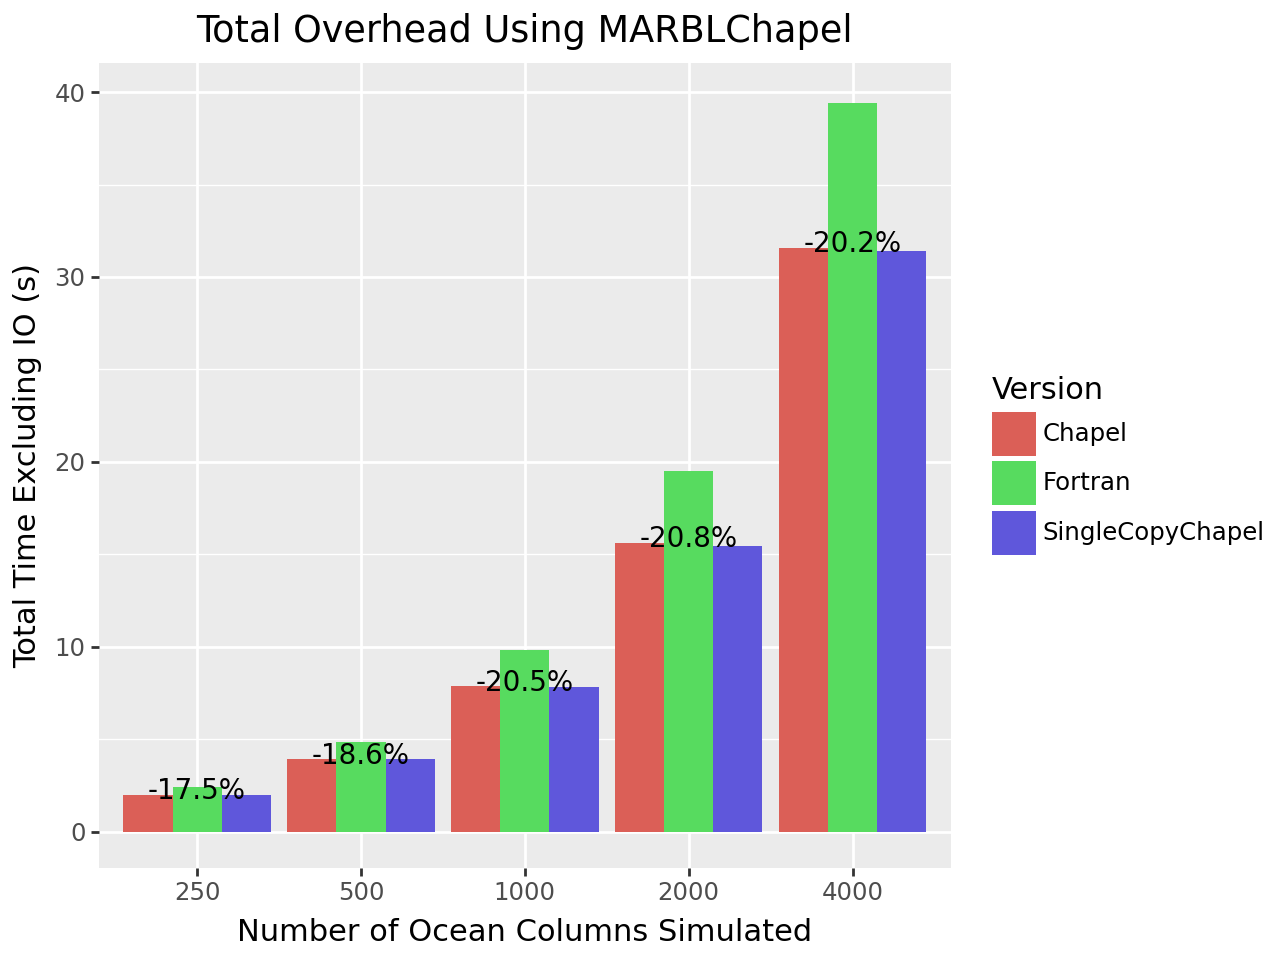

In [169]:
# Overall performance comparison
overhead_df = pd.DataFrame({'NumRuns':overheads.index, 'Label': overheads.values})
overhead_df

merged = data.copy().merge(overhead_df)
merged

merged['Label'] = merged['Label'].astype(str).str[0:5] + "%"
merged['Label'] = merged.apply(lambda row : row['Label'] if row['Version'] == 'Chapel' else None, axis=1)
p = ggplot(merged, aes(x='factor(OceanColumns)', y='Total Time (s)', fill='Version')) + geom_bar(position='dodge', stat='identity') + geom_text(aes(label='Label'), nudge_y=0.2, size=10)
p = p + labs (x='Number of Ocean Columns Simulated', y='Total Time Excluding IO (s)',title='Total Overhead Using MARBLChapel')
p 


Chapel  Setup Overhead:
NumRuns
50    -18.552155
100   -20.111901
200   -20.916681
400   -20.654928
800   -21.242891
Name: Setup Time (s), dtype: float64
Chapel  Stepping Overhead:
NumRuns
50     63.919137
100    41.038043
200    26.930989
400    25.362168
800    63.508835
Name: Stepping Time (s), dtype: float64
Chapel  Setting Overhead:
NumRuns
50     621.400000
100    577.444444
200    512.333333
400    509.222222
800    721.712329
Name: Setting Time (s), dtype: float64
Chapel  Compute Overhead:
NumRuns
50     56.303279
100    34.397524
200    21.063130
400    19.427257
800    55.552409
Name: Compute Time (s), dtype: float64
SingleCopyChapel  Setup Overhead:
NumRuns
50    -18.779929
100   -19.558834
200   -21.276631
400   -21.522423
800   -21.535742
Name: Setup Time (s), dtype: float64
SingleCopyChapel  Stepping Overhead:
NumRuns
50     60.862534
100    38.301630
200    25.749834
400    23.838102
800    59.050884
Name: Stepping Time (s), dtype: float64
SingleCopyChapel  Setting Overh

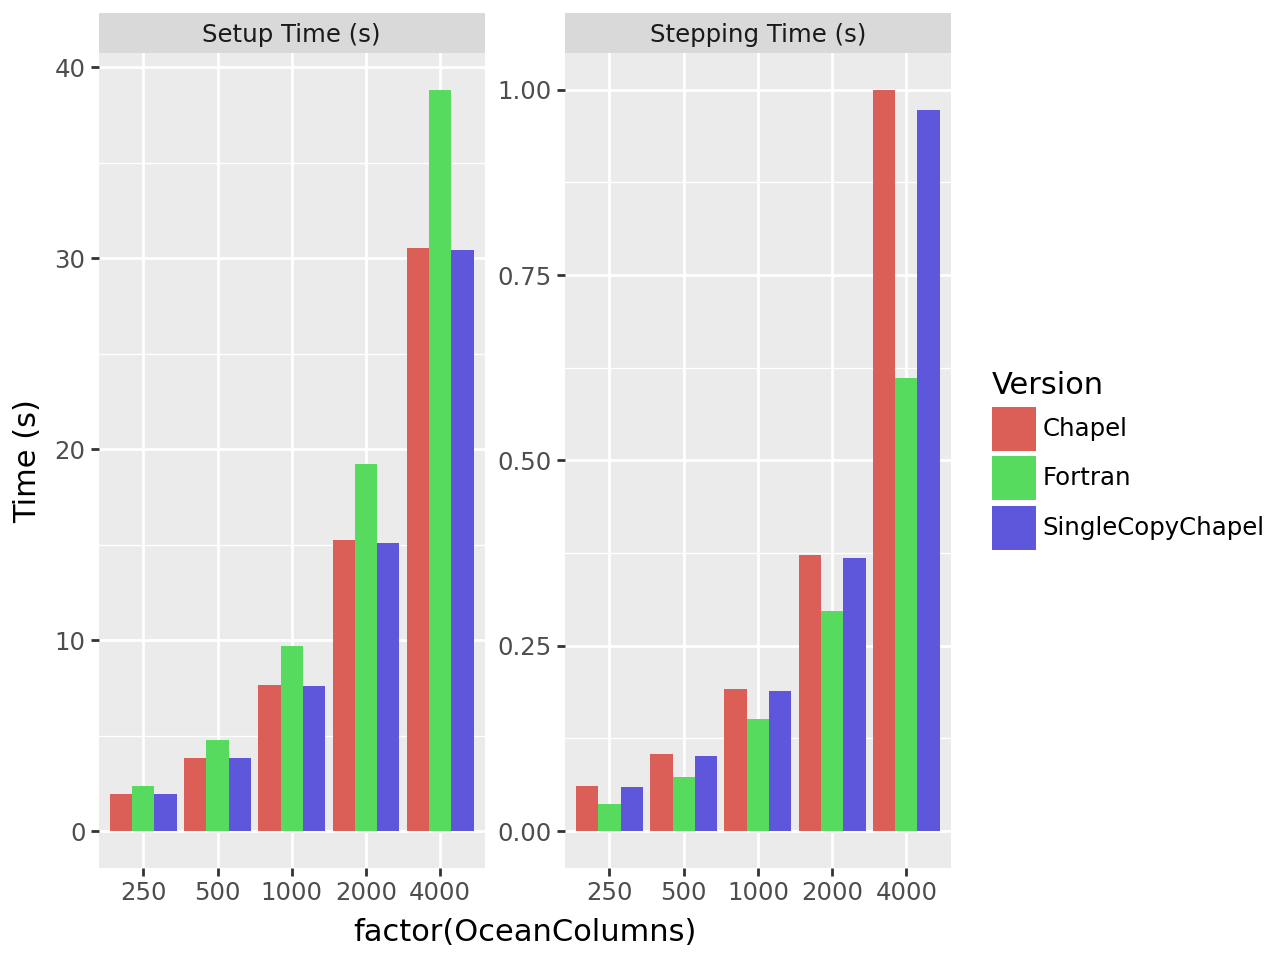

In [170]:
# split by phase type
melted = pd.melt(
  data,
    id_vars=['Version', 'NumRuns', 'OceanColumns'],
    value_vars=['Stepping Time (s)', 'Setup Time (s)'],
    var_name='PhaseType',
    value_name='Time (s)'
)
#melted = melted[melted['OceanColumns'] == 1000]
p = ggplot(melted, aes(x='factor(OceanColumns)', y='Time (s)', fill='Version')) + geom_bar(position='dodge', stat='identity') 
p = p + facet_wrap('PhaseType', scales='free')


def print_overheads(variant, original, name):
  print(name, ' Setup Overhead:')
  print((variant['Setup Time (s)'] - original['Setup Time (s)']) / original['Setup Time (s)'] * 100)
  print(name, ' Stepping Overhead:')
  print((variant['Stepping Time (s)'] - original['Stepping Time (s)']) / original['Stepping Time (s)'] * 100)

  print(name, ' Setting Overhead:')
  print((variant['Setting Time (s)'] - original['Setting Time (s)']) / original['Setting Time (s)'] * 100)
  print(name, ' Compute Overhead:')
  print((variant['Compute Time (s)'] - original['Compute Time (s)']) / original['Compute Time (s)'] * 100)

print_overheads(chapel, fortran, 'Chapel')
print_overheads(memcpy, fortran, 'SingleCopyChapel')
p

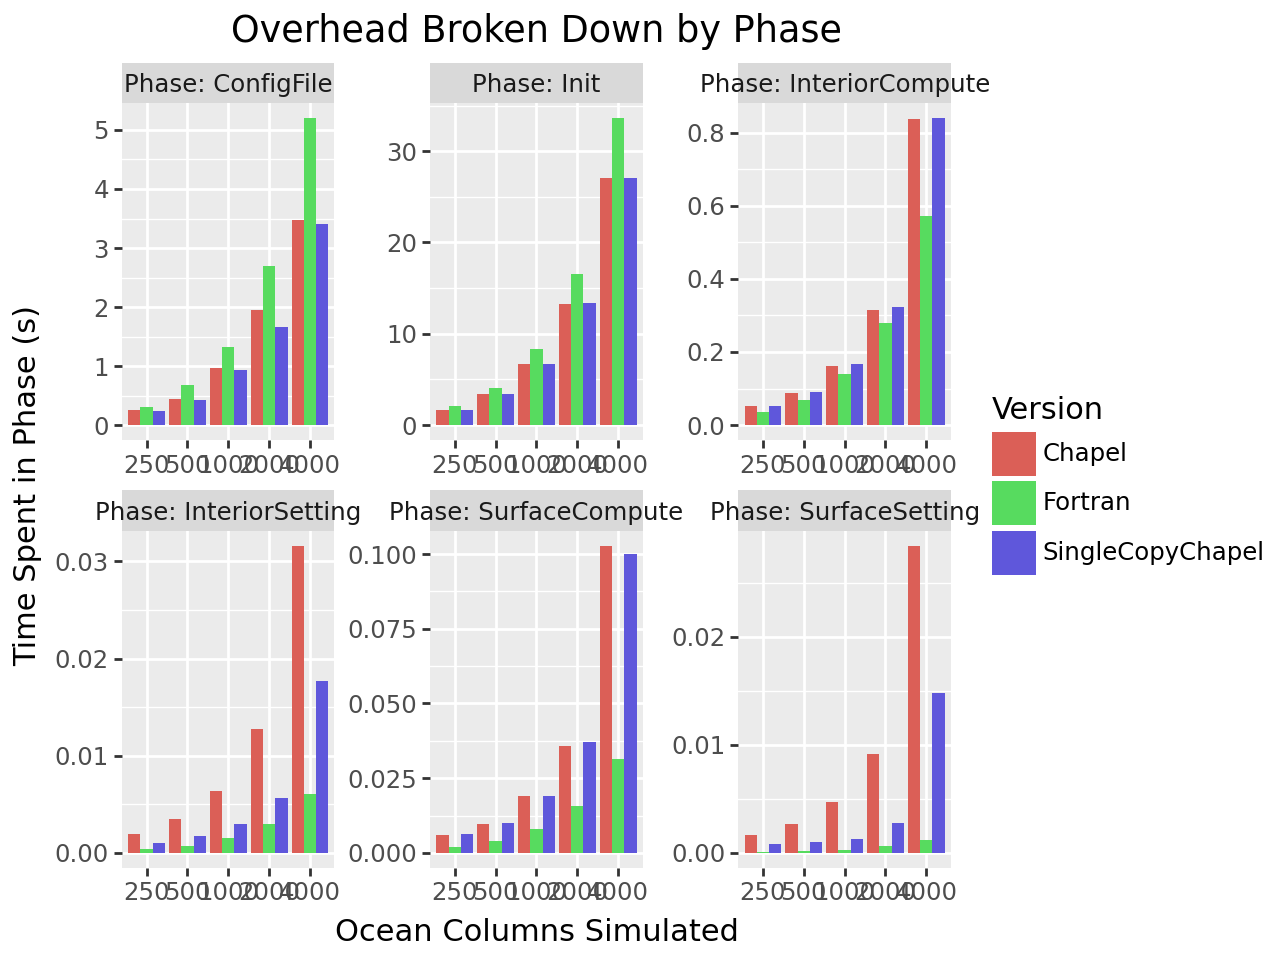

In [171]:
melted = pd.melt(
    data,
    id_vars=['Version', 'NumRuns', 'OceanColumns'],
    value_vars=total_columns,
    var_name='Phase',
    value_name='Time'
)
melted

p = ggplot(melted, aes(x='factor(OceanColumns)', y='Time', fill='Version')) + geom_bar(stat='identity',position='dodge') + facet_wrap('Phase',scales='free' ,labeller='label_both')
p = p + labs(x='Ocean Columns Simulated', y='Time Spent in Phase (s)', title='Overhead Broken Down by Phase')
p

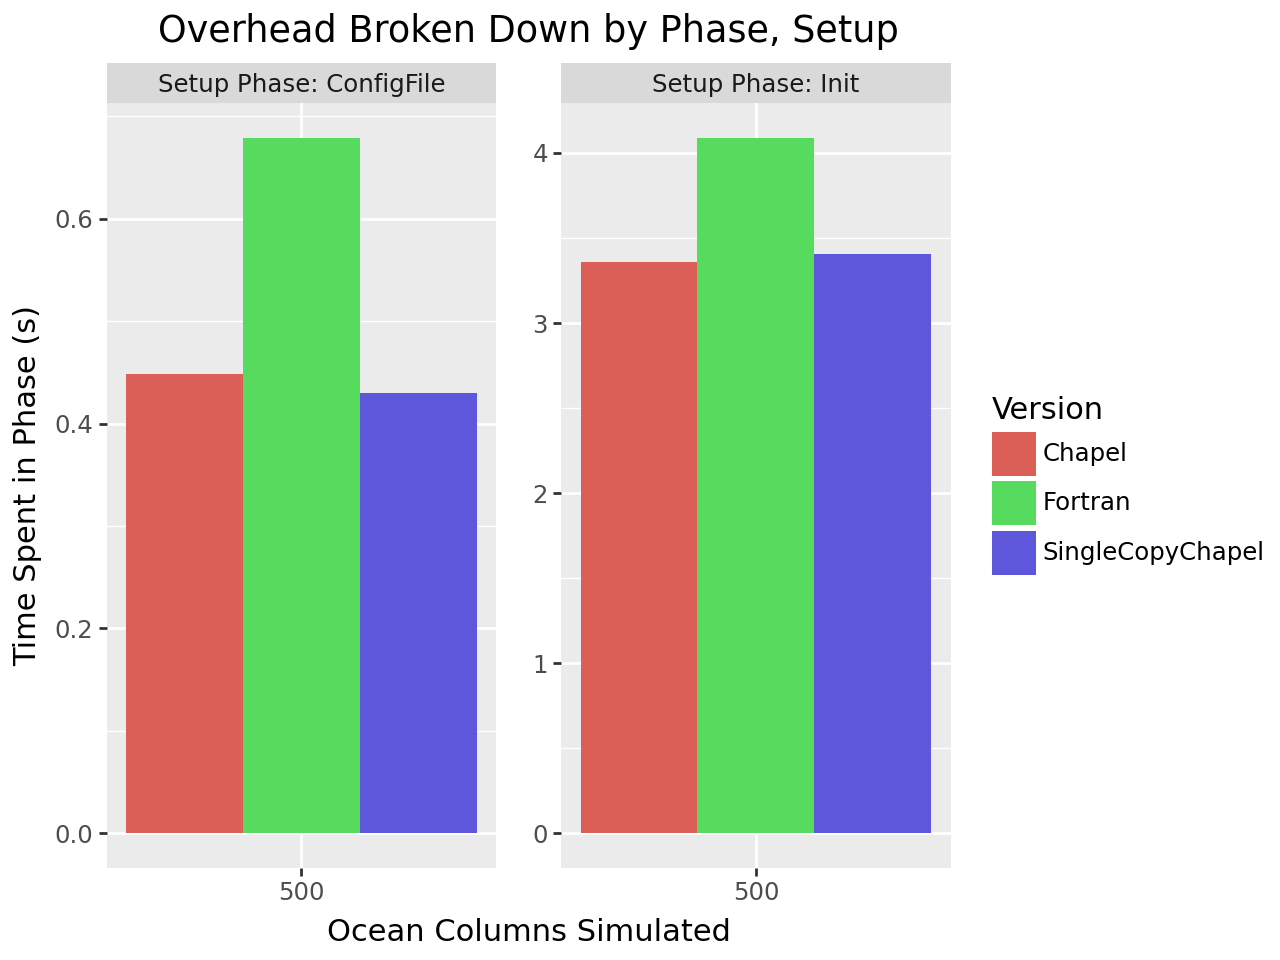

In [172]:
# Break down the overhead by its phase type. Starting with setup
melted = pd.melt(
    data,
    id_vars=['Version', 'NumRuns', 'OceanColumns'],
    value_vars=setup_columns,
    var_name='Setup Phase',
    value_name='Time'
)
melted

melted = melted[melted['NumRuns'] == 100]
p = ggplot(melted, aes(x='factor(OceanColumns)', y='Time', fill='Version')) + geom_bar(stat='identity',position='dodge') + facet_wrap('Setup Phase',scales='free' ,labeller='label_both')
p = p + labs(x='Ocean Columns Simulated', y='Time Spent in Phase (s)', title='Overhead Broken Down by Phase, Setup')
p

/global/homes/n/neth/.local/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_bar : Removed 10 rows containing missing values.


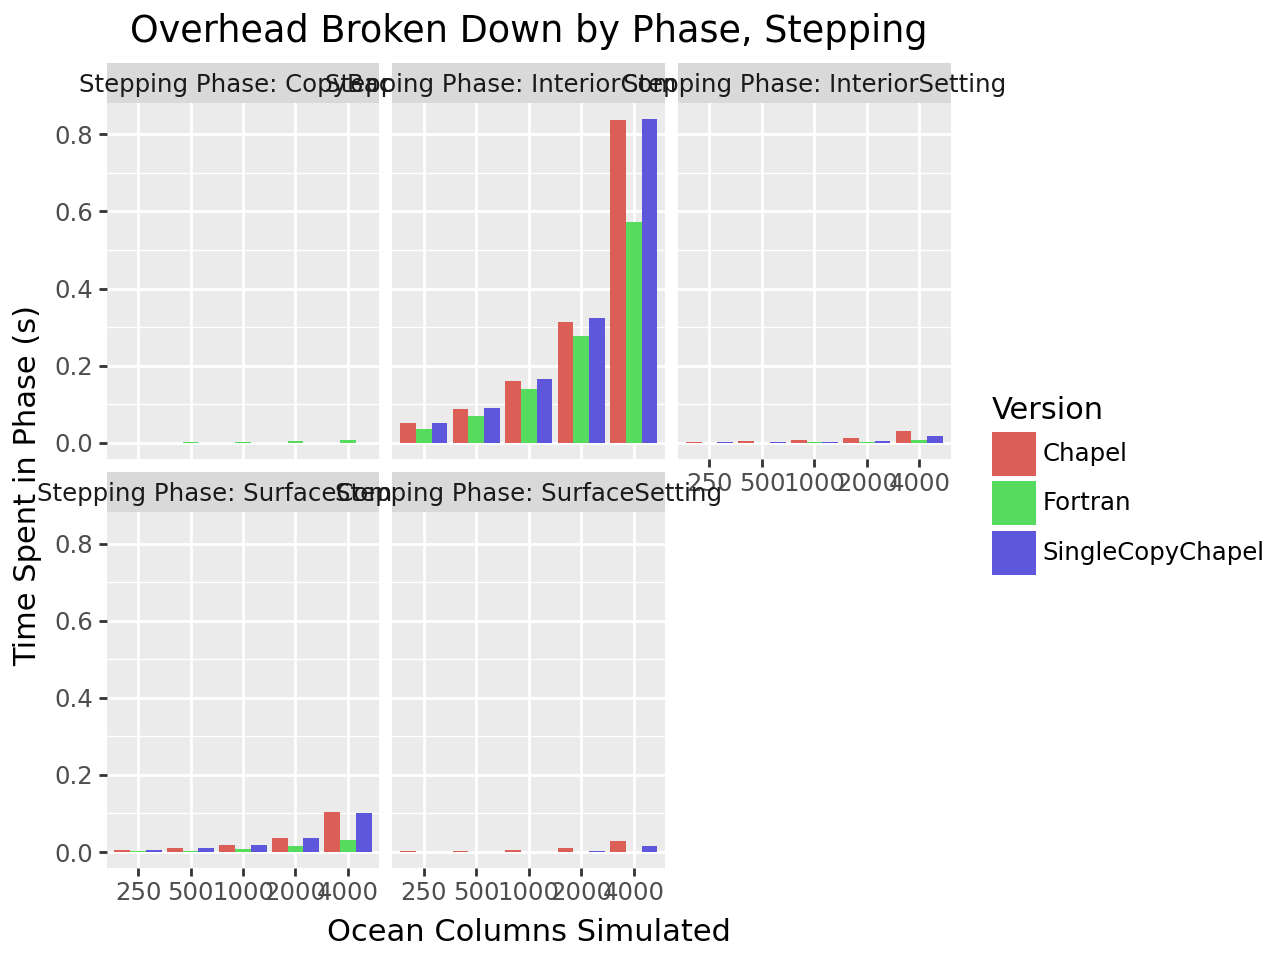

In [173]:
# Same for stepping
melted = pd.melt(
    data,
    id_vars=['Version', 'NumRuns', 'OceanColumns'],
    value_vars=stepping_columns,
    var_name='Stepping Phase',
    value_name='Time'
)

melted

stepping_data=melted
p = ggplot(melted, aes(x='factor(OceanColumns)', y='Time', fill='Version')) + geom_bar(stat='identity',position='dodge') + facet_wrap('Stepping Phase' ,labeller='label_both')
p = p + labs(x='Ocean Columns Simulated', y='Time Spent in Phase (s)', title='Overhead Broken Down by Phase, Stepping')
p

In [174]:
# Single-step time for Michelle's question

stepping_data
fstep_time = stepping_data[stepping_data['Version'] == 'Fortran']['Time'].sum() / 500
cstep_time = stepping_data[stepping_data['Version'] == 'Chapel']['Time'].sum() / 500

print(fstep_time, cstep_time)
print(1/fstep_time, 1/cstep_time)

0.0023715999999999997 0.00345544
421.65626581211 289.39874516704094


In [175]:
# Now need to make the scaling plots
weak_data = pd.read_csv('weak-scaling.csv')
strong_data = pd.read_csv('strong-scaling.csv')

strong_data['TotalColumns'] = strong_data['NodeCount'] * strong_data['RunsPerNode'] * 5

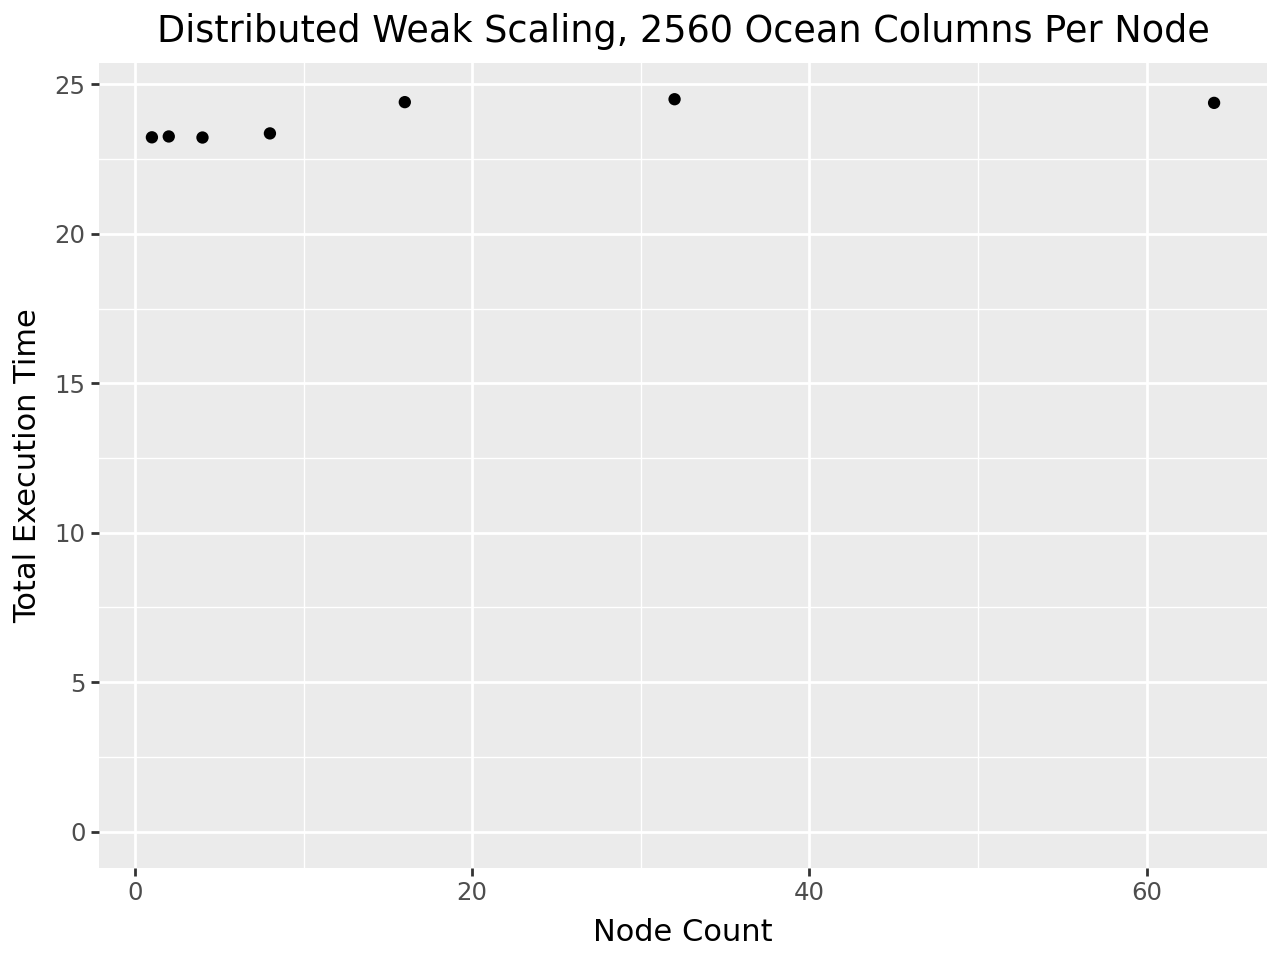

In [176]:
# Weak scaling plot
p = ggplot(weak_data, aes(x='NodeCount', y='Time')) + geom_point()
p = p + labs(x="Node Count", y='Total Execution Time', title="Distributed Weak Scaling, 2560 Ocean Columns Per Node")
p = p + scale_y_continuous(limits=(0,None))
p

    NodeCount  Series  Total Execution Time
0           1   Ideal             22.924800
1           2   Ideal             11.462400
2           4   Ideal              5.731200
3           8   Ideal              2.865600
4          16   Ideal              1.432800
5          32   Ideal              0.716400
6          64   Ideal              0.358200
7           1  Actual             22.924800
8           2  Actual             11.632400
9           4  Actual              5.906830
10          8  Actual              2.997890
11         16  Actual              1.552890
12         32  Actual              0.842186
13         64  Actual              0.474653


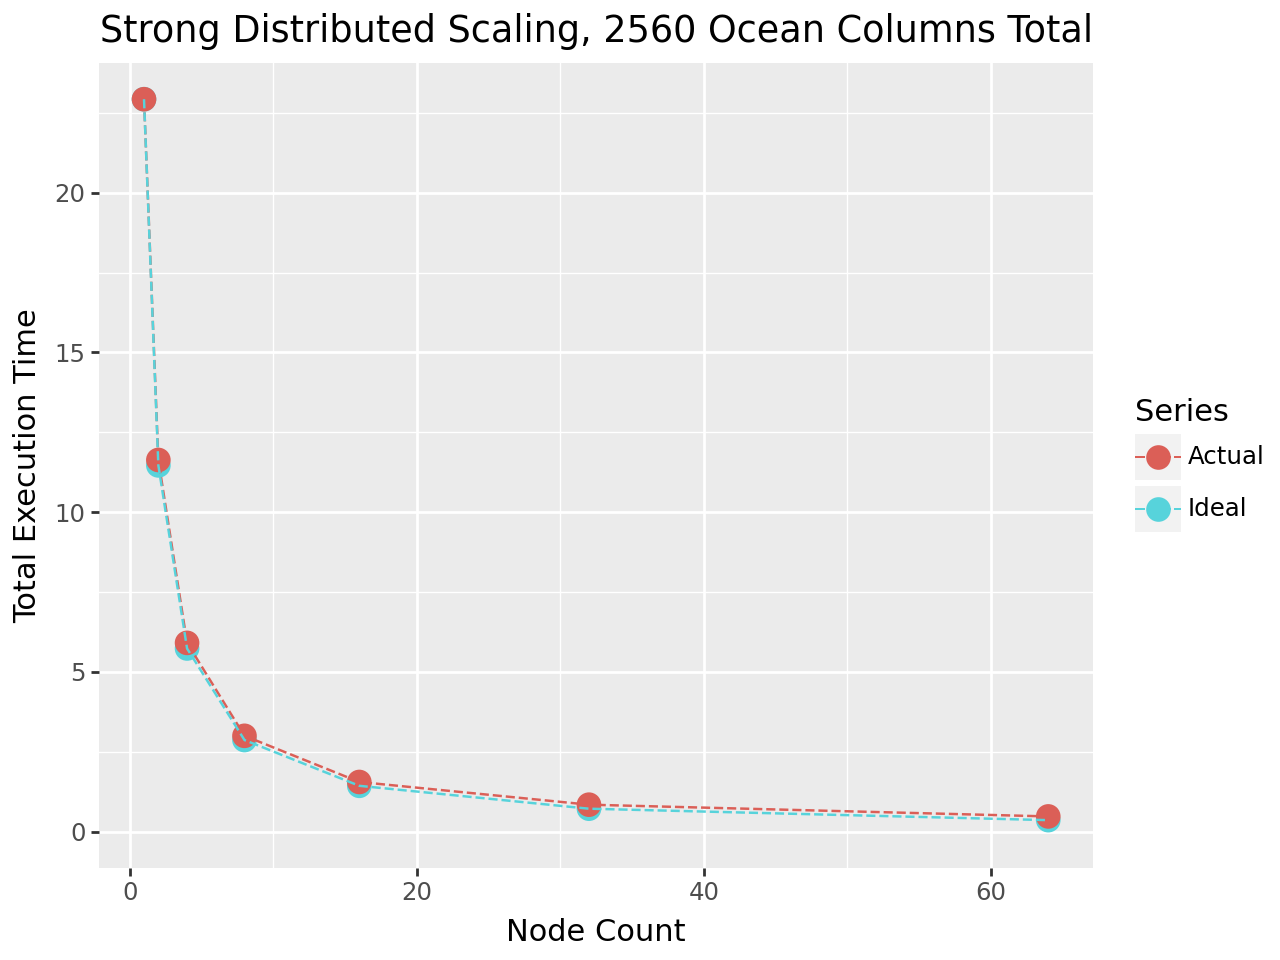

In [177]:
# Strong Scaling plots

one_node_time = strong_data[strong_data['NodeCount'] == 1]['Time'].values[0]

strong_data['Ideal'] = one_node_time / strong_data['NodeCount']

melted = pd.melt(strong_data, id_vars=['NodeCount'], value_vars=['Ideal', 'Time'], var_name='Series', value_name='Total Execution Time')
melted['Series'] = melted['Series'].str.replace('Time', 'Actual')

print(melted)
p = ggplot(melted, aes(x='NodeCount', y='Total Execution Time', color='Series')) + geom_point(size=4)
p = p + geom_line(linetype='dashed')
p = p + labs(x='Node Count', y='Total Execution Time', title='Strong Distributed Scaling, 2560 Ocean Columns Total')
p = p + scale_y_continuous(limits=(0,None))
p